In [108]:
import matplotlib.pyplot as plt
import numpy as np

In [70]:
# считываем файл
file_name = 'data/frag.R1.fastq'

all_reads = []

with open(file_name) as f:
    i = 0
    read = ''
    for l in f:
        if i == 4:
            i = 0

        if i == 1:
            read = l[:-1]
        elif i == 3:
            all_reads.append((read, l[:-1]))

        i += 1

# 1. GC состав

По файлам fastq определил, что используется Illumina 1.5, значит для оценки качества нуклеотида нужно вычитать 64 из ASCII значения символа

In [54]:
QUALITY_BASE = 64

In [83]:
# функция для подсчета GC-состава в одном риде с учетом качества нуклеотидов 
# (можно настроить фильтрацию нуклеотидов с неприемлемым качеством)
def count_gc(read, quality, filt=False, quality_threshold=20):
    gc = 0
    total = 0
    
    for i, n in enumerate(read):
        if not filt or (filt and ord(quality[i]) - QUALITY_BASE > quality_threshold):
            total += 1
            if n.upper() in ['G', 'C']:
                gc += 1
    
    gc_perc = 0
    if total != 0:
        gc_perc = (gc / total) * 100
    quality = (total / len(read)) * 100
    
    return gc_perc, quality

# функция постройки графика GC-состава
def plot_gc_context(reads, filt='None', filt_read_threshold=50, filt_n_threshold=20):
    
    filt_n = False
    filt_read = False
    
    if filt == 'Nucleotide':
        filt_n = True
    elif filt == 'Read':
        filt_n = True
        filt_read = True
    
    gc = []
    
    for r in reads:
        cur_gc = count_gc(r[0], r[1], filt_n, filt_n_threshold)
                
        if (not filt_read and cur_gc[-1] != 0) or (filt_read and cur_gc[-1] > filt_read_threshold):
            gc.append(cur_gc[0])
    
    plt.hist(gc, bins=50, range=(0, 100))

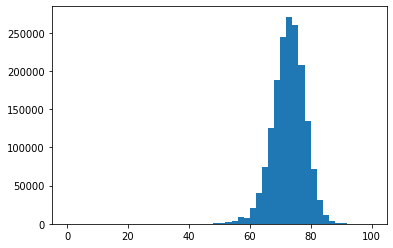

In [84]:
plot_gc_context(all_reads)

Удалим нуклеотиды с качеством меньше или равным 20

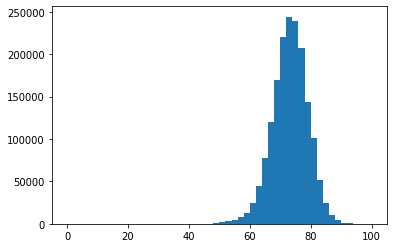

In [85]:
plot_gc_context(all_reads, 'Nucleotide', filt_n_threshold=20)

Удалим риды у которых количество нуклеотидов с качеством меньшим или равным 20 более 50%

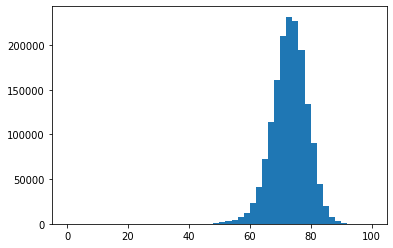

In [86]:
plot_gc_context(all_reads, 'Read', filt_read_threshold=50, filt_n_threshold=20)

# 2. Распределение качества

In [112]:
# сделаем из строк качества числовые значения 
qual = []

for r in all_reads:
    qual.append(np.fromstring(r[-1], np.int8) - QUALITY_BASE)

qual = np.array(qual)

<ipython-input-112-3b977933b2c5>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  qual.append(np.fromstring(r[-1], np.int8) - QUALITY_BASE)


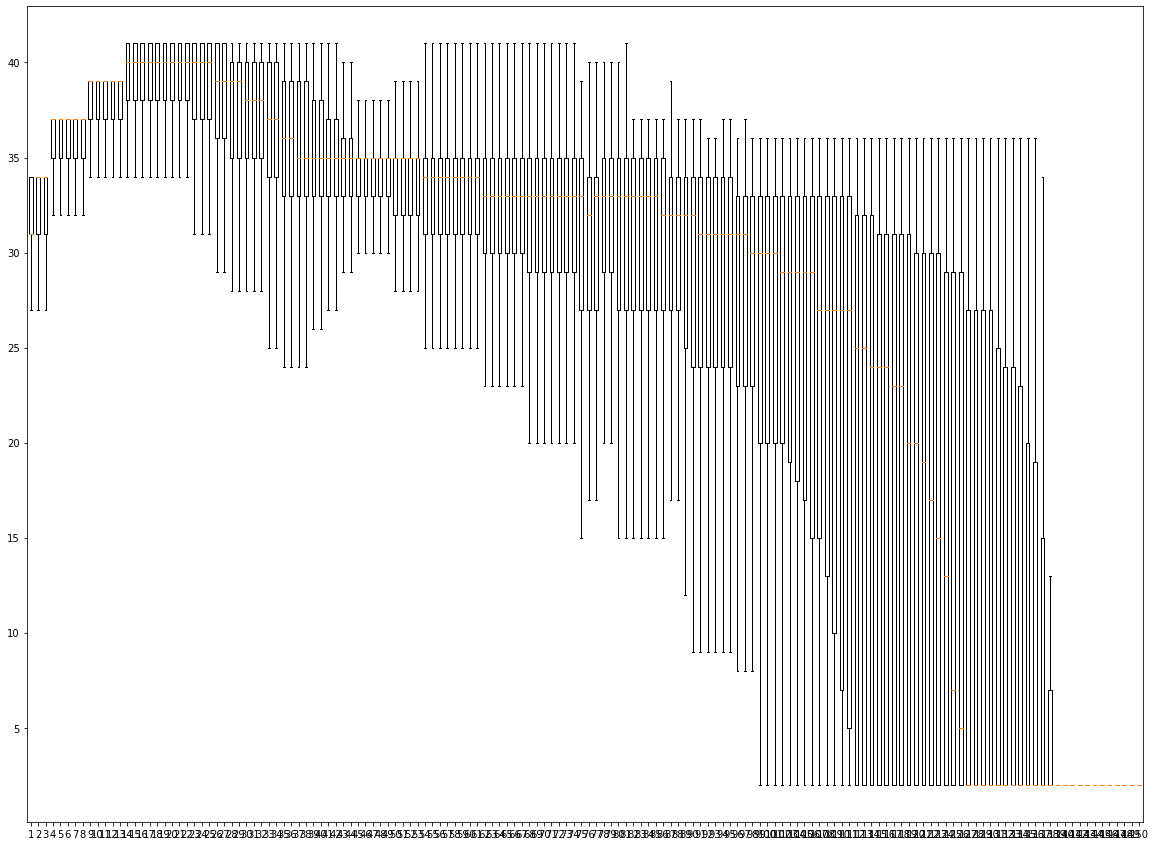

In [114]:
plt.figure(figsize=(20, 15))
plt.boxplot(qual, showfliers=False)
plt.show()

# 3. Проверка результатов

GC-состав

<img src="img/gc.png">

Per-base quality

<img src="img/quality.png">

Результаты совпадают

# 4.* Спектры k-меров

In [118]:
seqs = []

for r in all_reads:
    seqs.append(r[0])

In [119]:
k = 3

kmers = {}

for s in seqs:
    for i in range(len(s) - k):
        km = s[i: i + k]
        if km in kmers:
            kmers[km] += 1
        else:
            kmers[km] = 1

In [125]:
kmers

{'AAG': 1528548,
 'AGG': 4779305,
 'GGC': 10420294,
 'GCG': 12256099,
 'CGG': 11350070,
 'CGA': 7873234,
 'GAA': 2182709,
 'AGC': 5171778,
 'GCC': 10729196,
 'CCC': 8457756,
 'CCA': 4219901,
 'CAG': 4733666,
 'GCA': 4956823,
 'GGA': 4904143,
 'GAG': 6116173,
 'CAC': 5098710,
 'ACG': 4741868,
 'CGT': 4601906,
 'GTA': 970556,
 'TAG': 543165,
 'AGT': 1060117,
 'GTT': 1330365,
 'TTC': 2201892,
 'TCA': 2341762,
 'CAT': 2281155,
 'ATC': 3721702,
 'TCG': 7736828,
 'GTC': 4866391,
 'TCT': 1939407,
 'CTC': 6193042,
 'CGC': 12705557,
 'GGG': 8541462,
 'AGA': 1946315,
 'GAC': 5098254,
 'ACC': 5240312,
 'CCT': 4861211,
 'ATG': 2254331,
 'TGA': 2288859,
 'ACT': 1126664,
 'CTG': 4750097,
 'TGC': 4842042,
 'CCG': 11790508,
 'GCT': 5105384,
 'TCC': 5008651,
 'GAT': 3678625,
 'GGT': 4685695,
 'TTG': 836016,
 'GTG': 4590017,
 'CAA': 888041,
 'AAC': 1379434,
 'ACA': 1471370,
 'TGG': 3960379,
 'CTT': 1536152,
 'ATT': 249359,
 'TGT': 1381641,
 'TAC': 1011819,
 'CTA': 572601,
 'TTT': 179680,
 'AAA': 197262,

Не до конца разобрался, как правильно строить график по к-мерам, тут нужно как то учитывать теоретическую частоту появления к-мер в геноме?

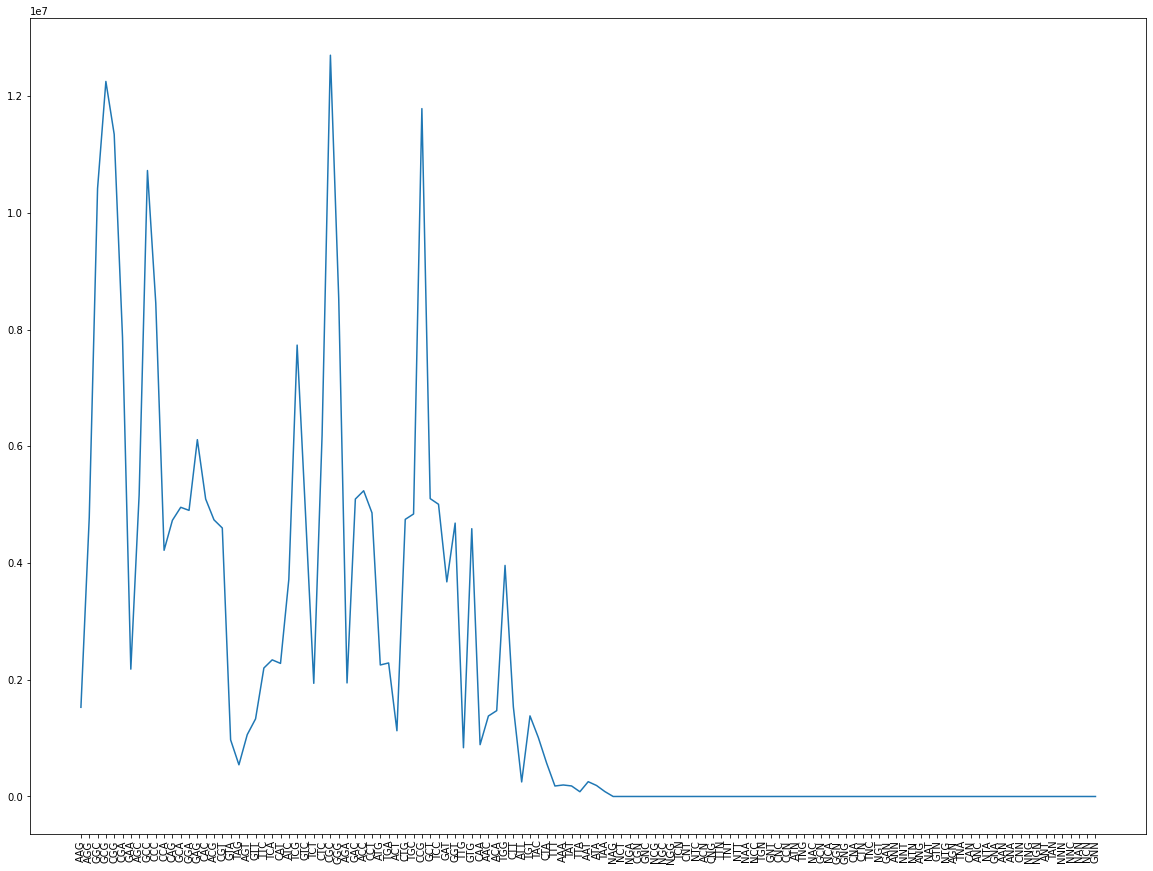

In [131]:
plt.figure(figsize=(20, 15))
plt.xticks(rotation=90)
plt.plot(list(kmers.keys()), list(kmers.values()))
plt.show()